In [1]:
import os
import clip.clip as clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
model, preprocess = clip.load('/data/datasets/Epickitchens100_clips/ViT-B-16.pt', device)


cuda:0


In [2]:
import json
with open("./annotations/fho_lta_taxonomy.json", encoding='utf-8') as f:
    taxonomy= json.load(f)
with open("./annotations/my_annotations/lta_taxonomy_id_label.json", encoding='utf-8') as f:
    taxonomy_id= json.load(f)

In [3]:
nouns_list=taxonomy["nouns"]
verbs_list=taxonomy["verbs"]

In [4]:


print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda:0
Current cuda device: 0
Count of using GPUs: 2


In [5]:
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image
class EGO4D_center(Dataset):
    def __init__(self, data_path,anno_path, transform=None, target_transform=None):
        super(EGO4D_center, self).__init__()
        self.data_path = data_path
        self.anno_path = anno_path
        self.transform = transform
        self.target_transform= target_transform
        import pandas as pd
        annotations = pd.read_csv(self.anno_path, header=None, delimiter=',')
        self.img_name = list(annotations.values[:, 0])
        self.verb_labels=list(annotations.values[:,1])
        self.noun_labels= list(annotations.values[:,2])

        self.transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ])

        self.target_transform = transforms.Compose([
            transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
        ])
        
    def __len__(self):
        return len(self.noun_labels)
    
    def __getitem__(self, idx):
        # file 경로
        img_path     = self.img_name[idx] + '.jpg'
        full_path    = os.path.join(self.data_path, img_path)
        # torchvision로 이미지 로드
        # image = read_image(full_path)
        image = Image.open(full_path)
        noun_label = self.noun_labels[idx]
        verb_label = self.verb_labels[idx]
        # transform 적용
        if self.transform:
            image = self.transform(image)
        # if self.target_transform:
        #     image = self.target_transform(image)
        # image, label return
        return image, noun_label,verb_label, full_path


In [6]:
EGO_datasets=EGO4D_center('/data/datasets/ego4d_center/lta/images','./annotations/my_annotations/lta_total.csv',transform=True)
len(EGO_datasets)

39197

In [7]:
text_inputs = torch.cat([clip.tokenize(f"a first-person view photo of the person act with {c}") for c in nouns_list]).to(device)

# One sample Test code

The sample is about
noun:[metal_(lead,_metal,_steel)]
verb:[hold_(support,_grip,_grasp)]
id: 247


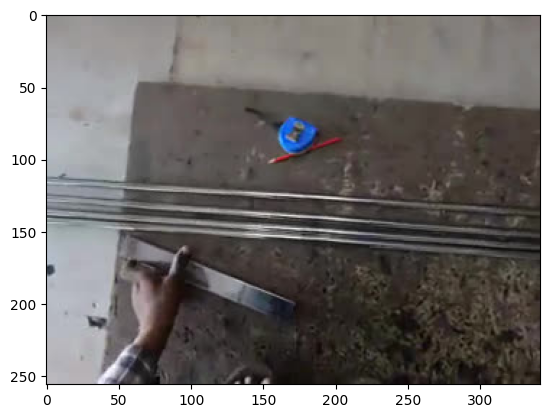


Top predictions:

tape_measure_(measure,_measurement): 4.42%
         crowbar: 2.33%
metal_(lead,_metal,_steel): 2.29%
       sharpener: 2.22%
          vacuum: 1.93%


In [8]:
sample=EGO_datasets[30000]
print(f"The sample is about\nnoun:[{nouns_list[sample[1]]}]\nverb:[{verbs_list[sample[2]]}]")
print(f"id: {sample[1]}")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(sample[3])
plt.imshow(img)
plt.show()
image_input = sample[0].unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{nouns_list[index]:>16s}: {100 * value.item():.2f}%")

In [9]:
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{nouns_list[index]:>16s}: {100 * value.item():.2f}%")
    print(int(index))



Top predictions:

tape_measure_(measure,_measurement): 4.42%
415
         crowbar: 2.33%
117
metal_(lead,_metal,_steel): 2.29%
247
       sharpener: 2.22%
359
          vacuum: 1.93%
446


# Prompt Tuning

In [29]:
image_template=[
    'A fisrt person picture of acting with {}.',
    # 'A person is holding {} in their hand.',
    # 'A person is playing with {}.',
    # 'A person is interacting with {}.',
    # 'A person is manipulating {}.',
    # 'A person is using {} to do something.',
    'A fisrt person view picture of people interactiong with {}.',
    # 'a person is using {}.'
    'A first person view of interacting with {}.',
    'A first person view of someone interacting with {}.',
    'A first person perspective of using {}.',
    'An immersive view of someone engaging with {}.',
    'A first person image of someone working with {}.',
    'An up-close view of someone manipulating {}.',
    'A first person shot of someone playing with {}.',
    'A first person view of someone operating {}.',
    'A first person image of someone utilizing {}.',
    'An intimate view of someone utilizing {}.',
    'A first person view of someone utilizing {}.',
]

# All test code

In [30]:
import random
text_inputs = torch.cat([clip.tokenize(
    random.choice(image_template).format(c)
    # f"a fisrt person picture of acting with {c}."
    ) for c in nouns_list])
text_inputs=text_inputs.to(device)
correct=0
#Loader
EGO_dataloaders=DataLoader(EGO_datasets,400,num_workers=12, shuffle=True)
with torch.no_grad():
    '''
    similarity : (B, num_noun)
    topk : The number you want to see top rank.
    If topk(r) , r>1 . you redefine acc metric code.
    '''
    for a in EGO_dataloaders:
        data=a[0]
        label=a[1]#noun
        image_features = model.encode_image(data.to(device))
        text_features = model.encode_text(text_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity.topk(1)
        
        # If topk(r) , r>1 . you redefine acc metric code.
        for i,k in enumerate(indices):
            pred=list(k)# k is 1-d tensor, label[i] is 1d list
            if pred[0]==label[i]:
                correct+=1
acc=correct/len(EGO_datasets)
print(acc)
with open('./result_ego4d.txt', 'a') as f:
    f.write("\nver5")
    f.write(f"\n\t{format(acc*100, '.2f')}%")



0.07475061866979615
